In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import cell as cl

plt.style.use('seaborn-whitegrid')
#plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)


In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 8.0  # final time
dt = 0.001  # fixed time step for Euler forward method
rA = 1.5   # maximum interaction distance


In [3]:
# Solvers using different force functions
solver_poly = cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, 1)
solver_cubic = cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, 1)
solver_gls = cbmos.CBMSolver(ff.gls, scpi.solve_ivp, 1)

In [4]:
params_cubic = {'mu': 5.70}
params_poly = {'muA': 0.21*9.1, 'muR':9.1, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0)}
params_gls_sc = {'mu': 1.95, 'a':-2*np.log(0.002/1.95)}
params_gls = {'mu': 1.95, 'a': 7.51}

In [5]:
defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'piecewise quadratic': defcolors[5], 'GLS': defcolors[6], 'GLS sc': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.', 'GLS sc': '-.'}

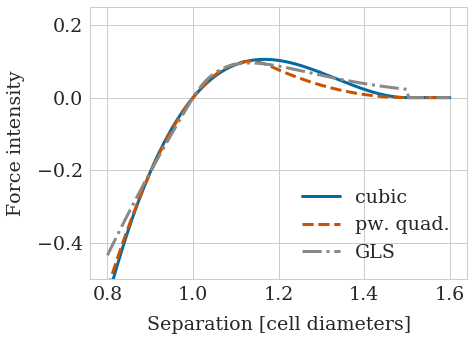

In [6]:
## plot the force functions for comparison - gls still has a free parameter


x_vals = np.linspace(0.8, 1.6, 200)
plt.figure()
plt.plot(x_vals,
         ff.cubic(x_vals, **params_cubic),
         label="cubic", color=colors['cubic'], linestyle=linestyles['cubic'])
plt.plot(x_vals,
         ff.piecewise_polynomial(x_vals, **params_poly),
         label="pw. quad.", color=colors['piecewise quadratic'], linestyle=linestyles['pw. quad.'])
plt.plot(x_vals,
         ff.gls(x_vals, **params_gls),
         label="GLS" , color=colors['GLS'], linestyle=linestyles['GLS'])
#plt.plot(1.0, 0.0, linestyle='', marker='o', color='grey')
#plt.text(1.020, -1.1, 'rest length', color='grey')
plt.xlabel('Separation [cell diameters]')
plt.ylabel('Force intensity')
plt.ylim([-0.5, 0.25])
plt.legend()
plt.savefig('plot_gls_cubic_pw_quad.pdf', bbox_inches='tight')
plt.savefig('plot_gls_cubic_pw_quad.eps', bbox_inches='tight')

In [7]:
ff.gls(np.array([1.0, 1.49]), **params_gls)

array([0.        , 0.02410296])

In [8]:
params = {'cubic': params_cubic, 'piecewise quadratic': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}
solvers = {'cubic': solver_cubic, 'piecewise quadratic': solver_poly, 'GLS': solver_gls, 'GLS sc': solver_gls}

In [9]:
t_data = np.linspace(0, 5.0, 100)
sols = {'cubic': [], 'piecewise quadratic': [], 'GLS': [], 'GLS sc': []}
for perturbation in [0.05, 0.16, 0.27, 0.38, 0.49]:
    
    cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [1.0 + perturbation], proliferating=False)]
    
    for force in ['cubic', 'piecewise quadratic', 'GLS', 'GLS sc']:
        hist = solvers[force].simulate(cell_list, t_data, params[force], {}, raw_t=False) 
        y = np.array([c.position for clist in hist for c in clist]).reshape(-1, 2)    
        sols[force].append(y[:, 1] - y[:,0])

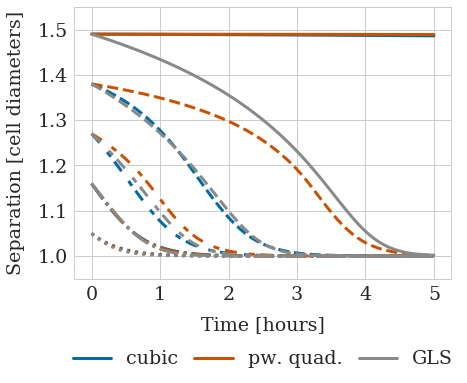

In [10]:
labels = {'cubic': 'cubic', 'piecewise quadratic': 'pw. quad.', 'GLS': 'GLS', 'GLS sc': 'GLS'}
for force in ['cubic', 'piecewise quadratic', 'GLS']:
    plt.plot(t_data, sols[force][0], color=colors[force], linestyle = ':')
    plt.plot(t_data, sols[force][1], color=colors[force], linestyle = '-.')
    plt.plot(t_data, sols[force][2], color=colors[force], dashes=[4, 4, 2, 2])
    plt.plot(t_data, sols[force][3], color=colors[force], linestyle='--')
    plt.plot(t_data, sols[force][4], color=colors[force], label=labels[force], linestyle = '-')

#plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(-0.05,-0.4,1.1,0.2), mode='expand', ncol=3)
plt.xlabel('Time [hours]')
plt.ylabel('Separation [cell diameters]')
plt.ylim((0.95,1.55))
plt.savefig('adhesion_dynamics.pdf', bbox_inches='tight')
plt.savefig('adhesion_dynamics.eps', bbox_inches='tight')

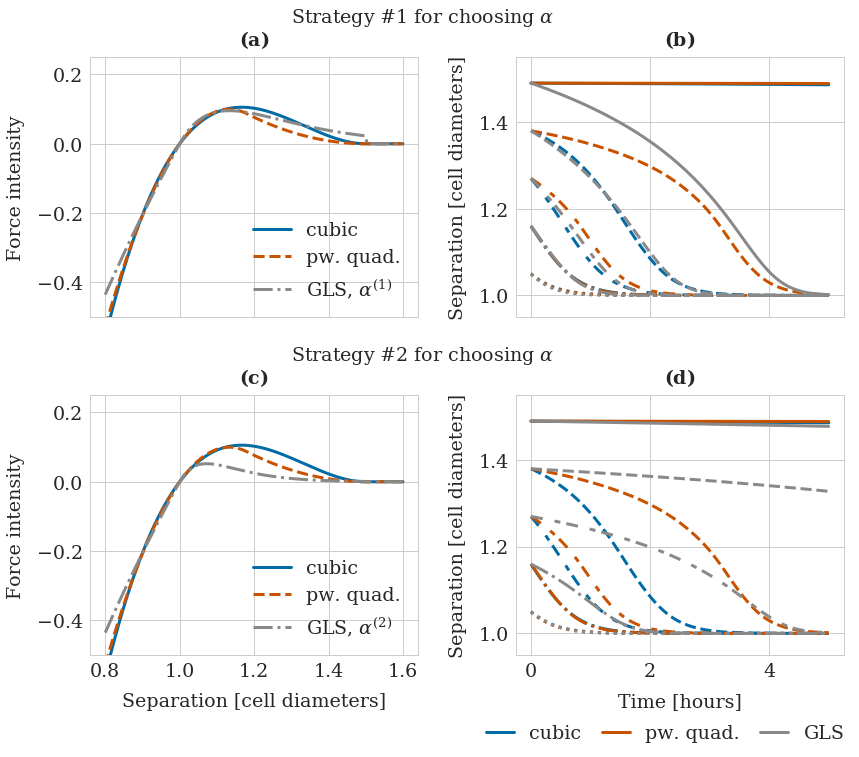

In [41]:
# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13.5, 11), sharex='col', gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

# ax1
ax1.plot(x_vals, ff.cubic(x_vals, **params_cubic),
         label="cubic", color=colors['cubic'], linestyle=linestyles['cubic'])
ax1.plot(x_vals, ff.piecewise_polynomial(x_vals, **params_poly),
         label="pw. quad.", color=colors['piecewise quadratic'], linestyle=linestyles['pw. quad.'])
ax1.plot(x_vals, ff.gls(x_vals, **params_gls),
         label=r"GLS, $\alpha^{(1)}$" , color=colors['GLS'], linestyle=linestyles['GLS'])
#plt.plot(1.0, 0.0, linestyle='', marker='o', color='grey')
#plt.text(1.020, -1.1, 'rest length', color='grey')
ax1.set(ylabel='Force intensity')
ax1.set_ylim([-0.5, 0.25])
ax1.legend()
ax1.set_title(r'$\bf{(a)}$')

ax1.text(1.3, 0.35, r'Strategy #1 for choosing $\alpha$', fontsize='xx-large')

# ax2
for force in ['cubic', 'piecewise quadratic', 'GLS']:
    ax2.plot(t_data, sols[force][0], color=colors[force], linestyle = ':')
    ax2.plot(t_data, sols[force][1], color=colors[force], linestyle = '-.')
    ax2.plot(t_data, sols[force][2], color=colors[force], dashes=[4, 4, 2, 2])
    ax2.plot(t_data, sols[force][3], color=colors[force], linestyle='--')
    ax2.plot(t_data, sols[force][4], color=colors[force], label=labels[force], linestyle = '-')

#plt.legend()
#ax2.legend(loc='upper center', bbox_to_anchor=(-0.1,-0.4,1.2,0.2), mode='expand', ncol=3, handlelength=1.5)
ax2.set(ylabel='Separation [cell diameters]')
ax2.set_ylim((0.95,1.55))
ax2.set_title(r'$\bf{(b)}$')

# ax3
ax3.plot(x_vals, ff.cubic(x_vals, **params_cubic),
         label="cubic", color=colors['cubic'], linestyle=linestyles['cubic'])
ax3.plot(x_vals, ff.piecewise_polynomial(x_vals, **params_poly),
         label="pw. quad.", color=colors['piecewise quadratic'], linestyle=linestyles['pw. quad.'])
ax3.plot(x_vals, ff.gls(x_vals, **params_gls_sc),
         label=r"GLS, $\alpha^{(2)}$" , color=colors['GLS'], linestyle=linestyles['GLS'])
#plt.plot(1.0, 0.0, linestyle='', marker='o', color='grey')
#plt.text(1.020, -1.1, 'rest length', color='grey')
ax3.set(xlabel='Separation [cell diameters]',ylabel='Force intensity')
ax3.set_ylim([-0.5, 0.25])
ax3.legend()
ax3.set_title(r'$\bf{(c)}$')

ax3.text(1.3, 0.35, r'Strategy #2 for choosing $\alpha$', fontsize='xx-large')


# ax4
for force in ['cubic', 'piecewise quadratic', 'GLS sc']:
    ax4.plot(t_data, sols[force][0], color=colors[force], linestyle = ':')
    ax4.plot(t_data, sols[force][1], color=colors[force], linestyle = '-.')
    ax4.plot(t_data, sols[force][2], color=colors[force], dashes=[4, 4, 2, 2])
    ax4.plot(t_data, sols[force][3], color=colors[force], linestyle='--')
    ax4.plot(t_data, sols[force][4], color=colors[force], label=labels[force], linestyle = '-')

#plt.legend()
ax4.legend(loc='upper center', bbox_to_anchor=(-0.145,-0.4,1.2,0.2), mode='expand', ncol=3, handlelength=1.5)
ax4.set(xlabel='Time [hours]', ylabel='Separation [cell diameters]')
ax4.set_ylim((0.95,1.55))
ax4.set_title(r'$\bf{(d)}$')


# add a big axis, hide frame
#fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.grid(False)
#plt.xlabel('Time [hours]')
#plt.ylabel('Separation [cell diameters]')
plt.savefig('Fig6_combined.pdf', bbox_inches='tight')
plt.savefig('Fig6_combined.png', bbox_inches='tight')